# PS2#10 - The Gauss-Markov theorem
<div style="text-align: right;font-size: 0.8em">Last updated: 2022-11-16</div>

This notebook requires `numpy` and `matplotlib` to run. If the following cell raises an error, install them first.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 6) # Default figsize
np.random.seed(42)

# Objective

The purpose of this notebook is to illustrate the Gauss-Markov theorem, which can be stated as follows.

Let $Y$ be a random variable taking values in $\mathbb{R}^N$ such that $$Y = \Phi\cdot \bar w + \epsilon,$$ where $\bar w\in\mathbb{R}^{M+1}$ is an unknown weights vector, $\Phi$ is a known feature matrix, and $\epsilon$ is a noise random variable that satisfies 
1. $\mathbb{E}[\epsilon] = 0$;
2. $\mathrm{Var}[\epsilon] = \sigma^2\cdot I$.

Define the mean-square error of an estimator $w$ of $\bar w$ as $$\mathrm{MSE}[w] = \mathbb{E}[\lVert w - \bar w\rVert^2]$$
Finally, let $$w = C\cdot Y$$ be a linear, unbiased estimator (LUE) of $\bar w$, and let $$w_\mathrm{LS} = (\Phi^\top\Phi)^{-1}\Phi^\top \cdot Y$$ be the least-squares estimator of $\bar w$.
Then, $$\mathrm{MSE}[w_\mathrm{LS}] \leq \mathrm{MSE}[w].$$
In other words, the least-squares estimator is the best linear, unbiased estimator (BLUE) of $\bar w$.

# Illustration

We illustrate it by comparing the performance of the least squares estimator $w_\mathrm{LS}$ against that of the regularized least-squares estimator $w_\lambda$, defined as $$w_\lambda = (\Phi^\top\Phi+\lambda\cdot I)^{-1}\Phi^\top\cdot Y.$$

We consider an example with two-dimensional weigths, with ground truth $\bar w = (1~1)^\top$.
We constuct $\Phi$ by assuming that we have $\mathbf{x}_1, \dots, \mathbf{x}_N\in\R$ data points, and the $n^\text{th}$-row of $\Phi$ is $(1~x_n)$.
Additionally, we assume that $\epsilon$ is Gaussian with variance $0.1$.

To sum up, we have the following ground truth for $Y$: $$y_n = 1 + x_n + \mathcal{N}(0, 0.1).$$

The following cell plots a two realizations of $Y$ with $N = 50$:

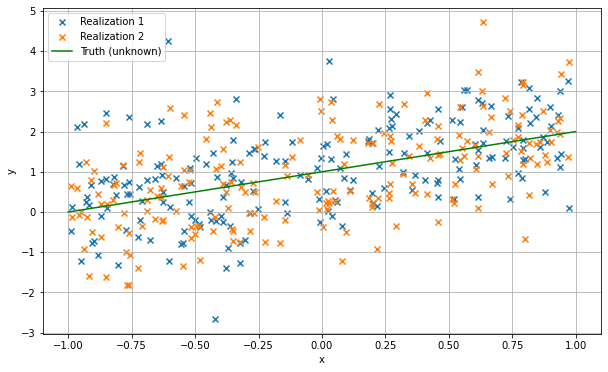

In [2]:
N = 200
a = -1
b = 1
D = 2
wbar = np.ones(D, dtype=float)
sigma2 = 1
X = np.random.uniform(a, b, (N, D-1))
Phi = np.hstack((np.ones((X.shape[0], 1)), X))
PhiTPhi = Phi.T @ Phi

def get_realization():
    Y = Phi @ wbar + np.random.normal(0, sigma2, N)
    return Y

if D == 2:
    X_plot = np.linspace(a, b, 1001)
    Y_plot = 1 + X_plot

    plt.scatter(X, get_realization(), label='Realization 1', marker='x')
    plt.scatter(X, get_realization(), label='Realization 2', marker='x')
    plt.plot(X_plot, Y_plot, label='Truth (unknown)', color='green')
    plt.legend(loc='best')
    plt.xlabel('x')
    plt.ylabel('y')
    _=plt.grid(True)
else:
    print(X.shape, get_realization().shape, wbar.shape)

We can compute the regularized and unregularized least-squares estimates as a function of the data:

In [3]:
def ls_estimate(y, reg):
    b = Phi.T @ y
    estimate = np.linalg.solve(PhiTPhi + reg * np.eye(D), b)
    return estimate

For different realizations of $Y$, we get different realization of the estimates. The following cell plots the different realizations of both the unregularized and regularized estimates.

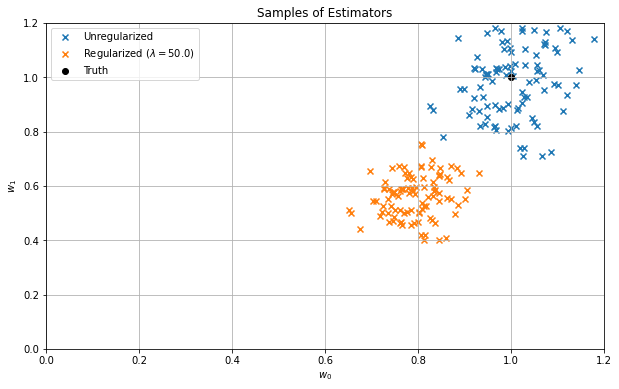

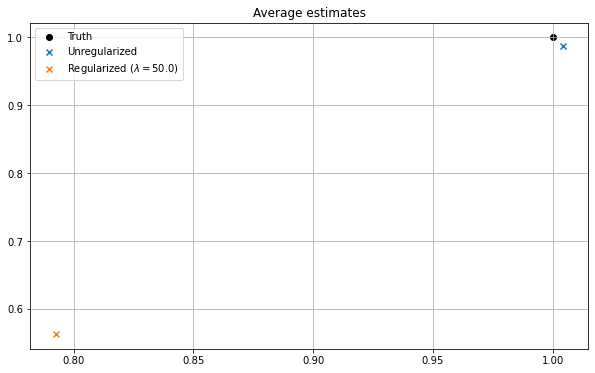

In [4]:
def get_realizations_of_ls_estimates(R, regularizers):
    regularizers = np.atleast_1d(regularizers)
    L = regularizers.shape[0]
    w = np.zeros((L, R, D), dtype=float)
    y = np.zeros((R, N), dtype=float)

    for r in range(R):
        y[r] = get_realization()
        for n, reg in enumerate(regularizers):
            w[n, r] = ls_estimate(y[r], reg)
    return w

def plot_realizations(l):
    R = 100  # Number of realizations
    w_LS, w_lambda = get_realizations_of_ls_estimates(R, [0., l])
    avg_LS = w_LS.mean(axis=0)
    avg_lambda = w_lambda.mean(axis=0)

    plt.figure()
    plt.scatter(w_LS[:, 0], w_LS[:, 1], label='Unregularized', marker='x')
    plt.scatter(w_lambda[:, 0], w_lambda[:, 1], label=r'Regularized ($\lambda = {:.1f}$)'.format(l), marker='x')
    plt.scatter([1], [1], label='Truth', color='black')
    plt.xlabel(r'$w_0$')
    plt.ylabel(r'$w_1$')
    plt.legend(loc='best')
    plt.xlim(0, 1.2)
    plt.ylim(0, 1.2)
    plt.title("Samples of Estimators")
    plt.grid()

    plt.figure()
    plt.scatter([1], [1], label='Truth', color='black')
    plt.scatter([avg_LS[0]], [avg_LS[1]], marker='x', label='Unregularized')
    plt.scatter([avg_lambda[0]], [avg_lambda[1]], marker='x', label=r'Regularized ($\lambda = {:.1f}$)'.format(l))
    plt.title('Average estimates')
    plt.grid()
    plt.legend()

if D == 2:
    plot_realizations(50)

The unregularized version is unbiased, but has a larger variance than the regularized version. Since the MSE is the sum of these two terms, there seems to be a trade-off appearing.

We can use the following formulas to compute the bias, variance, and $\mathrm{MSE}$ of a linear estimator of the form $w = C\cdot Y$: $$\begin{aligned}
    \mathbb{E}[w - \bar w] &= (C\cdot\Phi - I) \bar w,\\
    \mathrm{Var}[w] &= \sigma^2 C\cdot C^\top\\
    \mathrm{MSE}[w] &= \lVert\mathbb{E}[w - \bar w]\rVert^2 + \mathrm{Tr[\mathrm{Var}[w]]}
\end{aligned}$$

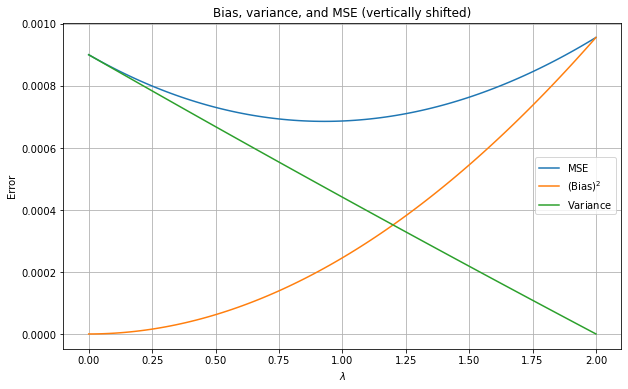

In [5]:
def get_bias_variance(regularizers):
    bias = np.zeros_like(regularizers, dtype=float)
    vars = np.zeros_like(regularizers, dtype=float)
    I = np.eye(D)
    for i, reg in enumerate(regularizers):
        C = np.linalg.inv(PhiTPhi + reg * I) @ Phi.T
        bias[i] = np.linalg.norm((C @ Phi - I) @ wbar)**2
        vars[i] = sigma2 * np.trace(C @ C.T)
    return bias, vars

regularizers = np.linspace(0, 2, 100)
bias, var = get_bias_variance(regularizers)
mse = bias + var

plt.figure()
plt.plot(regularizers, mse - min(var), label=r'$\mathrm{MSE}$')
plt.plot(regularizers, bias, label=r'$(\mathrm{Bias})^2$')
plt.plot(regularizers, var-min(var), label=r'$\mathrm{Variance}$')
plt.xlabel(r'$\lambda$')
plt.ylabel('Error')
plt.legend(loc='best')
plt.grid()
_=plt.title('Bias, variance, and MSE (vertically shifted)')

We clearly see on this plot that a little of regularization decreases the $\mathrm{MSE}$ of the estimator.
We can plot the estimations of the regularized estimator:

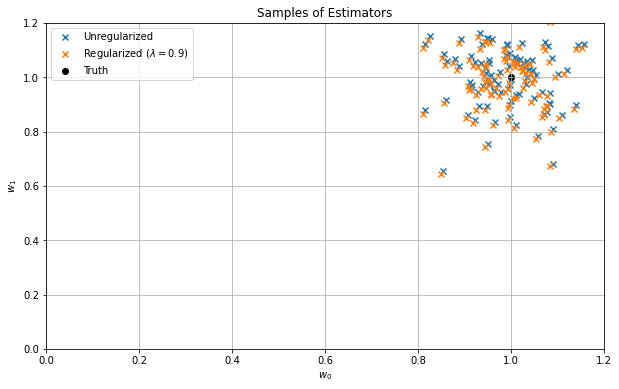

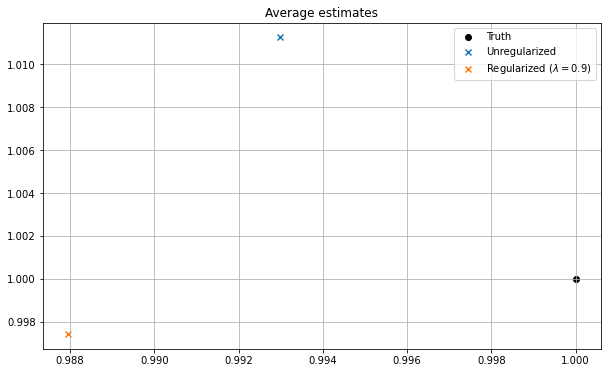

In [6]:
best_mse_ind = np.argmin(mse)
best_reg = regularizers[best_mse_ind]
plot_realizations(best_reg)